In [1]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

from jax.config import config
config.update("jax_debug_nans", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples
from models.train_utils import create_input_iter

In [4]:
from datasets import load_data

In [5]:
n_nodes = 100
n_batch = 8

In [6]:
train_ds, norm_dict = load_data("nbody", 3, n_nodes, n_batch, 234, small=True)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [7]:
tuple(map(float, norm_dict['mean']))

(505.32177734375, 502.5718994140625, 493.03143310546875)

In [8]:
batches = create_input_iter(train_ds)
x_data = next(batches)
x = x_data[0][0]
cond = x_data[1][0]

In [9]:
k = 20

In [10]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x, k)

In [11]:
def translate_pbc(coordinates, translation_vector, box_size):
    """
    Translate a batch of coordinates and apply periodic boundary conditions.

    :param coordinates: np.array of shape (batch, points, 3) containing the coordinates
    :param translation_vector: np.array of shape (3,) containing the translation vector
    :param box_size: float representing the box size
    :return: np.array of shape (batch, points, 3) containing the translated coordinates
    """

    # Translate the coordinates
    translated_coordinates = coordinates + translation_vector

    # Apply periodic boundary conditions
    translated_coordinates = np.mod(translated_coordinates, box_size)

    return translated_coordinates

## EGNN; equivariance test

Just the base GNN. Rotate the box and check if the output is equivariant.

In [12]:
from models.egnn_jax import EGNN
from models.graph_utils import rotate_representation

In [13]:
coord_mean, coord_std, box_size = norm_dict['mean'], norm_dict['std'], 1000.
unit_cell = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])

In [14]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, graph, pos):
        return jax.vmap(EGNN(k=k), in_axes=(0, 0, 0, 0, None, None, None, None))(graph, pos, None, None, coord_mean, coord_std, box_size, unit_cell)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

In [15]:
d2 = np.sum(x ** 2, axis=-1, keepdims=True)

### Rotation equivariance

In [16]:
pos = x
pos_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45, np.array([0., 0., 1.]))

In [17]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_out, _ = model.init_with_output(rng, graph, pos)

In [18]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_rot_out, _ = model.init_with_output(rng, graph, pos_rot)

In [19]:
pos_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(pos_out, 45, np.array([0., 0., 1.]))

In [20]:
pos_rot_out / pos_out_rot

Array([[[ 0.9951502 ,  1.0007632 ,  0.99939895],
        [ 0.98182046,  0.98245776,  0.9997861 ],
        [ 0.9966697 ,  1.0008055 ,  1.003612  ],
        ...,
        [ 0.9999493 ,  0.9998432 ,  1.0001348 ],
        [ 1.0000833 ,  1.0004468 ,  0.9997655 ],
        [ 1.0002505 ,  1.0003049 ,  0.9985682 ]],

       [[ 1.000221  ,  0.99980795,  1.0000356 ],
        [ 0.99904567,  1.0009365 ,  1.0005811 ],
        [ 1.0020342 ,  1.0001078 ,  1.0001073 ],
        ...,
        [ 0.94387186,  1.0010251 ,  1.0000707 ],
        [ 0.9508984 ,  1.003205  ,  1.0001658 ],
        [ 1.0008755 ,  0.96106696,  0.99998426]],

       [[ 1.0042273 ,  0.9958108 ,  0.99818194],
        [ 0.9999358 ,  1.0000798 ,  1.0000052 ],
        [ 0.9901762 ,  1.260592  ,  0.998531  ],
        ...,
        [ 0.96396965,  0.9966209 ,  0.99948543],
        [ 0.99994814,  0.99968374,  0.9999016 ],
        [ 0.99999946,  1.0000684 ,  1.0000244 ]],

       ...,

       [[ 0.9937783 ,  0.9764678 ,  0.99986017],
        [ 0

### Translation equivariance

In [21]:
tran = np.array([-0.45, 0.9, -1.2])[None, None, :]
pos_tran = pos + tran
pos_out_tran = pos_out + tran

In [22]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_tran_out, _ = model.init_with_output(rng, graph, pos_tran)

In [23]:
pos_tran_out / pos_out_tran

Array([[[0.9999998 , 1.0000001 , 1.0000004 ],
        [1.0000002 , 0.99999976, 1.0000056 ],
        [1.0000001 , 0.9999999 , 1.0000001 ],
        ...,
        [1.        , 0.99999994, 0.99999994],
        [1.0000001 , 0.99999964, 0.9999999 ],
        [1.        , 1.        , 1.        ]],

       [[0.99999976, 0.99999976, 1.0000007 ],
        [0.9999989 , 0.99999994, 1.0000006 ],
        [1.0000002 , 0.9999998 , 0.9999999 ],
        ...,
        [1.0000001 , 1.0000001 , 1.0000002 ],
        [1.0000001 , 0.99999994, 0.99999994],
        [1.0000001 , 1.000001  , 0.9999992 ]],

       [[0.99999994, 0.99999976, 1.        ],
        [0.9999999 , 0.9999996 , 1.        ],
        [0.99999934, 0.9999999 , 0.9999998 ],
        ...,
        [0.9999999 , 1.0000002 , 1.        ],
        [1.0000004 , 1.0000011 , 0.9999999 ],
        [0.99999994, 0.9999993 , 1.0000001 ]],

       ...,

       [[0.9999999 , 1.0000097 , 1.        ],
        [1.0000001 , 1.0000042 , 1.        ],
        [1.0000002 , 1

In [24]:
tran = np.array([700., 100., 800.])
pos_tran = (translate_pbc(pos * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std
pos_out_tran = (translate_pbc(pos_out * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std

In [25]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_tran_out, _ = model.init_with_output(rng, graph, pos_tran)

In [26]:
pos_tran_out / pos_out_tran

Array([[[ 1.0000002 ,  0.9999998 ,  0.9999986 ],
        [ 0.9999998 ,  0.9999994 ,  0.99999964],
        [ 0.9999999 , -1.5845557 ,  1.0000002 ],
        ...,
        [ 1.0000002 ,  0.9999991 ,  0.9999997 ],
        [ 0.9999999 ,  0.9999996 ,  1.0000006 ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 0.99999964,  0.9999999 ,  1.0000006 ],
        [ 1.0000001 ,  1.0000011 ,  0.99999946],
        [ 1.0000001 , -1.6719106 ,  0.9999996 ],
        ...,
        [-1.1833549 ,  1.0000001 ,  1.0000001 ],
        [-1.0363185 ,  0.9999998 ,  1.0000001 ],
        [ 0.99999994,  1.0000004 ,  0.99999976]],

       [[ 1.        ,  0.9999998 ,  1.0000002 ],
        [ 1.0000001 ,  1.0000002 ,  0.9999992 ],
        [ 0.99999815, -1.9414438 ,  0.99999976],
        ...,
        [ 0.99999815,  1.0000014 ,  0.9999998 ],
        [ 1.0000001 ,  0.9999997 ,  1.0000012 ],
        [ 1.        ,  1.0000002 ,  1.000063  ]],

       ...,

       [[-1.0200146 ,  1.0000002 ,  1.0000012 ],
        [ 0

## Look at VLB loss

In [27]:
from models.diffusion import VariationalDiffusionModel
from flax.core import FrozenDict
from models.diffusion_utils import loss_vdm
from models.train_utils import create_input_iter, param_count, train_step

In [28]:
train_ds, norm_dict_tmp = load_data("nbody", 3, 100, n_batch, 23, small=True)

In [29]:
batches = create_input_iter(train_ds)

In [30]:
x, conditioning, mask = next(batches)
x, conditioning, mask = x[0], conditioning[0], mask[0]

In [31]:
score_dict = FrozenDict({"k":20, "n_pos_features":3})  # GNN args
encoder_dict = decoder_dict = FrozenDict({})
norm_dict = FrozenDict({"x_mean":tuple(map(float, norm_dict_tmp['mean'])), "x_std":tuple(map(float, norm_dict_tmp['std'])), "box_size":1000.})  # GNN args
# norm_dict = FrozenDict({"x_mean":tuple(map(float, norm_dict_tmp['mean'])), "x_std":tuple(map(float, norm_dict_tmp['std'])), "box_size":None})  # GNN args
score = "egnn"

vdm = VariationalDiffusionModel(
          timesteps=0, 
          d_t_embedding=16,
          d_feature=3,
          score=score,
          score_dict=score_dict,
          n_classes=0,
          embed_context=True,
          d_context_embedding=16,
          noise_schedule="learned_linear",
          gamma_min=-8.,
          gamma_max=14.,
          use_encdec=False,
          encoder_dict=encoder_dict,
          decoder_dict=decoder_dict,
          norm_dict=norm_dict)

In [32]:
x.shape, conditioning.shape, mask.shape

((8, 100, 3), (8, 2), (8, 100))

In [33]:
rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng}, x, conditioning, mask);

795093


### Check rotational invariance of loss

In [34]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

795093


Array([ 35.651817 ,   7.7402015, -13.967949 , -16.54494  , -16.868437 ,
        51.77922  ,  45.742184 ,  45.444347 ], dtype=float32)

In [35]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45., np.array([0., 0., 1.]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

789623


Array([ 34.08485  ,   6.9078956, -14.033896 , -16.545162 , -16.868385 ,
        47.377666 ,  43.357357 ,  45.068016 ], dtype=float32)

In [36]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 11., np.array([0., 1. / np.sqrt(2), 1. / np.sqrt(2)]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

795313


Array([ 35.58208  ,   7.4426613, -13.982278 , -16.544945 , -16.868443 ,
        50.995296 ,  44.86525  ,  45.055294 ], dtype=float32)

### Check rotational invariance of loss (individual components)

In [37]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

795093


Array([5.2478615e+01, 2.4590548e+01, 2.7135105e+00, 2.1442725e-01,
       1.3214388e-02, 6.8445305e+01, 6.2380810e+01, 6.2357563e+01],      dtype=float32)

In [38]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45., np.array([0., 0., 1.]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

789623


Array([5.0911640e+01, 2.3758238e+01, 2.6475685e+00, 2.1419945e-01,
       1.3250518e-02, 6.4043732e+01, 5.9995983e+01, 6.1981232e+01],      dtype=float32)

In [39]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 93., np.array([0., 1. / np.sqrt(2), 1. / np.sqrt(2)]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

794653


Array([5.2269718e+01, 2.2672857e+01, 2.6950018e+00, 2.1312839e-01,
       1.3496276e-02, 6.0741249e+01, 6.2802681e+01, 6.0196693e+01],      dtype=float32)

### Check translational invariance of loss

In [40]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

795093


Array([ 35.651817 ,   7.7402015, -13.967949 , -16.54494  , -16.868437 ,
        51.77922  ,  45.742184 ,  45.444347 ], dtype=float32)

In [41]:
# Translate
tran = np.array([112., 12., -100.])
# x_tran = (translate_pbc(x * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std
x_tran = (x * coord_std + coord_mean + tran) / coord_std

loss_diff, loss_klz, loss_recon = vdm.apply(params, x_tran, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

795093


Array([ 35.653355 ,   7.7417345, -13.966391 , -16.543316 , -16.866732 ,
        51.780758 ,  45.7437   ,  45.446095 ], dtype=float32)

## Train

In [42]:
import optax

In [43]:
train_steps = 30_000

schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=3e-4, warmup_steps=1000, decay_steps=train_steps)
opt = optax.adamw(learning_rate=schedule, weight_decay=1e-4)

In [44]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4))
def train_step(state, batch, rng, model, loss_fn):
    """Train for a single step."""
    x, conditioning, mask = batch
    loss, grads = jax.value_and_grad(loss_fn)(state.params, model, rng, x, conditioning, mask)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics

In [45]:
import flax
from flax.training import train_state
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate


state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=opt)
pstate = replicate(state)

with trange(train_steps) as steps:
    for step in steps:

        rng, *train_step_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
        train_step_rng = np.asarray(train_step_rng)

        pstate, metrics = train_step(pstate, next(batches), train_step_rng, vdm, loss_vdm)
        steps.set_postfix(val=unreplicate(metrics["loss"]))

  0%|          | 0/30000 [00:00<?, ?it/s]

Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


  4%|▍         | 1311/30000 [07:54<2:53:09,  2.76it/s, val=18.385172]


KeyboardInterrupt: 

In [ ]:
from models.diffusion_utils import generate

x, conditioning, mask = next(batches)
x, conditioning, mask = x[0], conditioning[0], mask[0]

# Gen
x_samples = generate(vdm, unreplicate(pstate).params, rng, (8, 100), conditioning, mask=mask, steps=100).mean()


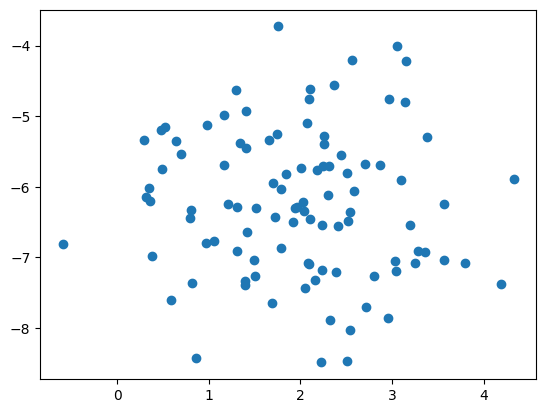

In [ ]:
idx = 2
plt.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1])